In [1]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, random_split, DataLoader, Subset
import torch.nn as nn
import torchvision.transforms.functional as TF
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class SegmentationOrientedDefectDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image, mask = self.augment(image, mask)

        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()

        return image, mask

    def augment(self, image, mask):
        # Random Horizontal Flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Then the Random Vertical Flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random rotation
        angle = random.choice([0, 90, 180, 270])
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)

        return image, mask

In [ ]:
dataset_path = 'combined_dataset'

image_dir = os.path.join(dataset_path, "images")
mask_dir = os.path.join(dataset_path, "masks")

full_dataset = SegmentationOrientedDefectDataset(image_dir, mask_dir, transform=True)

random_indices = random.sample(range(len(full_dataset)), 5000)
dataset = Subset(full_dataset, random_indices)

train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [31]:
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50

def get_deeplabv3(num_classes=1):
    model = deeplabv3_resnet50(pretrained=True)
    
    # Replace classifier head
    model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)
    
    return model

In [32]:
model = get_deeplabv3()
print(model)

c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [33]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [34]:
def dice_coefficient(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    return (2. * intersection) / (preds.sum() + targets.sum() + 1e-8)

def iou_score(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return intersection / (union + 1e-8)

In [35]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    best_val_dice = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_dice = 0.0

        for images, masks in tqdm(train_loader, desc="Training", leave=False):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_dice += dice_coefficient(outputs, masks).item()

        train_loss = train_loss / len(train_loader)
        train_dice = train_dice / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validating", leave=False):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)['out']
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_dice += dice_coefficient(outputs, masks).item()
                val_iou += iou_score(outputs, masks).item()

        val_loss = val_loss / len(val_loader)
        val_dice = val_dice / len(val_loader)
        val_iou = val_iou / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}\n")

        # Save checkpoint
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), "model_saved")
            print(f"Saved new best model (Dice: {val_dice:.4f})")

In [36]:
model = get_deeplabv3().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, train_loader, val_loader, optimizer, criterion, epochs=30)

Epoch [1/30]
Train Loss: 0.3447 | Dice: 0.4070
Val Loss: 0.2455 | Dice: 0.5218 | IoU: 0.3561

Saved new best model (Dice: 0.5218)


Epoch [2/30]
Train Loss: 0.1893 | Dice: 0.5373
Val Loss: 0.1533 | Dice: 0.5806 | IoU: 0.4129

Saved new best model (Dice: 0.5806)


Epoch [3/30]
Train Loss: 0.1326 | Dice: 0.5809
Val Loss: 0.1107 | Dice: 0.5984 | IoU: 0.4318

Saved new best model (Dice: 0.5984)


Epoch [4/30]
Train Loss: 0.1010 | Dice: 0.6055
Val Loss: 0.0929 | Dice: 0.6202 | IoU: 0.4522

Saved new best model (Dice: 0.6202)


Epoch [5/30]
Train Loss: 0.0813 | Dice: 0.6273
Val Loss: 0.0742 | Dice: 0.6267 | IoU: 0.4610

Saved new best model (Dice: 0.6267)


Epoch [6/30]
Train Loss: 0.0690 | Dice: 0.6429
Val Loss: 0.0684 | Dice: 0.6412 | IoU: 0.4756

Saved new best model (Dice: 0.6412)


Epoch [7/30]
Train Loss: 0.0630 | Dice: 0.6392
Val Loss: 0.0625 | Dice: 0.6421 | IoU: 0.4766

Saved new best model (Dice: 0.6421)


Epoch [8/30]
Train Loss: 0.0564 | Dice: 0.6529
Val Loss: 0.0573 | Dice: 0.6629 | IoU: 0.4987

Saved new best model (Dice: 0.6629)


Epoch [9/30]
Train Loss: 0.0517 | Dice: 0.6632
Val Loss: 0.0519 | Dice: 0.6551 | IoU: 0.4904



Epoch [10/30]
Train Loss: 0.0486 | Dice: 0.6724
Val Loss: 0.0513 | Dice: 0.6445 | IoU: 0.4780



Epoch [11/30]
Train Loss: 0.0461 | Dice: 0.6708
Val Loss: 0.0496 | Dice: 0.6473 | IoU: 0.4831



Epoch [12/30]
Train Loss: 0.0443 | Dice: 0.6762
Val Loss: 0.0463 | Dice: 0.6818 | IoU: 0.5201

Saved new best model (Dice: 0.6818)


Epoch [13/30]
Train Loss: 0.0417 | Dice: 0.6838
Val Loss: 0.0460 | Dice: 0.6879 | IoU: 0.5272

Saved new best model (Dice: 0.6879)


Epoch [14/30]
Train Loss: 0.0405 | Dice: 0.6898
Val Loss: 0.0443 | Dice: 0.6759 | IoU: 0.5130



Epoch [15/30]
Train Loss: 0.0402 | Dice: 0.6870
Val Loss: 0.0432 | Dice: 0.6892 | IoU: 0.5293

Saved new best model (Dice: 0.6892)


Epoch [16/30]
Train Loss: 0.0382 | Dice: 0.6984
Val Loss: 0.0447 | Dice: 0.6408 | IoU: 0.4756



Epoch [17/30]
Train Loss: 0.0379 | Dice: 0.6945
Val Loss: 0.0428 | Dice: 0.6692 | IoU: 0.5060



Epoch [18/30]
Train Loss: 0.0372 | Dice: 0.6958
Val Loss: 0.0420 | Dice: 0.6721 | IoU: 0.5094



Epoch [19/30]
Train Loss: 0.0353 | Dice: 0.7117
Val Loss: 0.0414 | Dice: 0.6735 | IoU: 0.5110



Epoch [20/30]
Train Loss: 0.0367 | Dice: 0.6971
Val Loss: 0.0416 | Dice: 0.6911 | IoU: 0.5308

Saved new best model (Dice: 0.6911)


Epoch [21/30]
Train Loss: 0.0363 | Dice: 0.7013
Val Loss: 0.0409 | Dice: 0.6748 | IoU: 0.5124



Epoch [22/30]
Train Loss: 0.0347 | Dice: 0.7091
Val Loss: 0.0400 | Dice: 0.6938 | IoU: 0.5339

Saved new best model (Dice: 0.6938)


Epoch [23/30]
Train Loss: 0.0333 | Dice: 0.7169
Val Loss: 0.0417 | Dice: 0.6782 | IoU: 0.5157



Epoch [24/30]
Train Loss: 0.0337 | Dice: 0.7135
Val Loss: 0.0403 | Dice: 0.6720 | IoU: 0.5107



Epoch [25/30]
Train Loss: 0.0336 | Dice: 0.7122
Val Loss: 0.0411 | Dice: 0.6681 | IoU: 0.5048



Epoch [26/30]
Train Loss: 0.0336 | Dice: 0.7143
Val Loss: 0.0402 | Dice: 0.6832 | IoU: 0.5221



Epoch [27/30]
Train Loss: 0.0336 | Dice: 0.7129
Val Loss: 0.0397 | Dice: 0.6759 | IoU: 0.5141



Epoch [28/30]
Train Loss: 0.0325 | Dice: 0.7234
Val Loss: 0.0393 | Dice: 0.7053 | IoU: 0.5474

Saved new best model (Dice: 0.7053)


Epoch [29/30]
Train Loss: 0.0320 | Dice: 0.7238
Val Loss: 0.0378 | Dice: 0.7065 | IoU: 0.5489

Saved new best model (Dice: 0.7065)


Epoch [30/30]
Train Loss: 0.0310 | Dice: 0.7296
Val Loss: 0.0393 | Dice: 0.6965 | IoU: 0.5373



In [37]:
torch.save(model.state_dict(), "deepnetv3.pth")

In [ ]:
def visualize_prediction(image, mask, pred, alpha=0.6):
    """
    Visualizes the image, ground truth, predicted mask, and overlay of predicted mask on image.
    
    Parameters:
        image (Tensor): Original image tensor (C, H, W)
        mask (Tensor): Ground truth mask tensor (1, H, W)
        pred (Tensor): Predicted binary mask tensor (1, H, W)
        alpha (float): Transparency factor for overlay
    """
    image_np = image.cpu().permute(1, 2, 0).numpy()
    mask_np = mask.cpu().squeeze().numpy()
    pred_np = pred.cpu().squeeze().numpy()

    overlay = image_np.copy()
    green_mask = np.zeros_like(image_np)
    green_mask[..., 1] = 1 
    overlay_mask = np.where(pred_np[..., None] > 0, green_mask, 0)
    overlay = (1 - alpha) * image_np + alpha * overlay_mask
    overlay = np.clip(overlay, 0, 1)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[2].imshow(pred_np, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[3].imshow(overlay)
    axs[3].set_title('Overlay on Image')

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
def predict_and_evaluate(model, test_loader, save_dir, threshold=0.5, num_visualize=5):
    
    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            preds = torch.sigmoid(outputs)
            preds_bin = (preds > threshold).float()

            for i in range(images.size(0)):
                pred_mask = preds_bin[i].squeeze().cpu().numpy() * 255
                pred_mask_img = Image.fromarray(pred_mask.astype(np.uint8))
                pred_mask_img.save(os.path.join(save_dir, f"pred_{idx * test_loader.batch_size + i}.png"))

                dice = dice_coefficient(preds_bin[i], masks[i])
                iou = iou_score(preds_bin[i], masks[i])
                dice_scores.append(dice.item())
                iou_scores.append(iou.item())

                if idx * test_loader.batch_size + i < num_visualize:
                    visualize_prediction(images[i], masks[i], preds_bin[i])

    print(f"\nAverage Dice Score on Test Set: {np.mean(dice_scores):.4f}")
    print(f"Average IoU Score on Test Set: {np.mean(iou_scores):.4f}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.32549024].


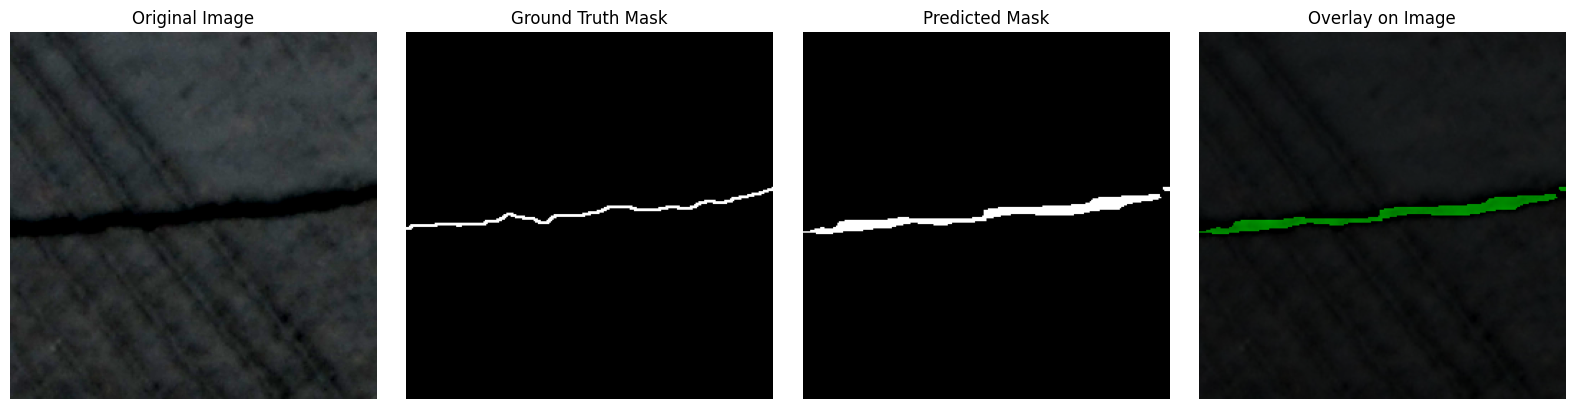

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.30980396].


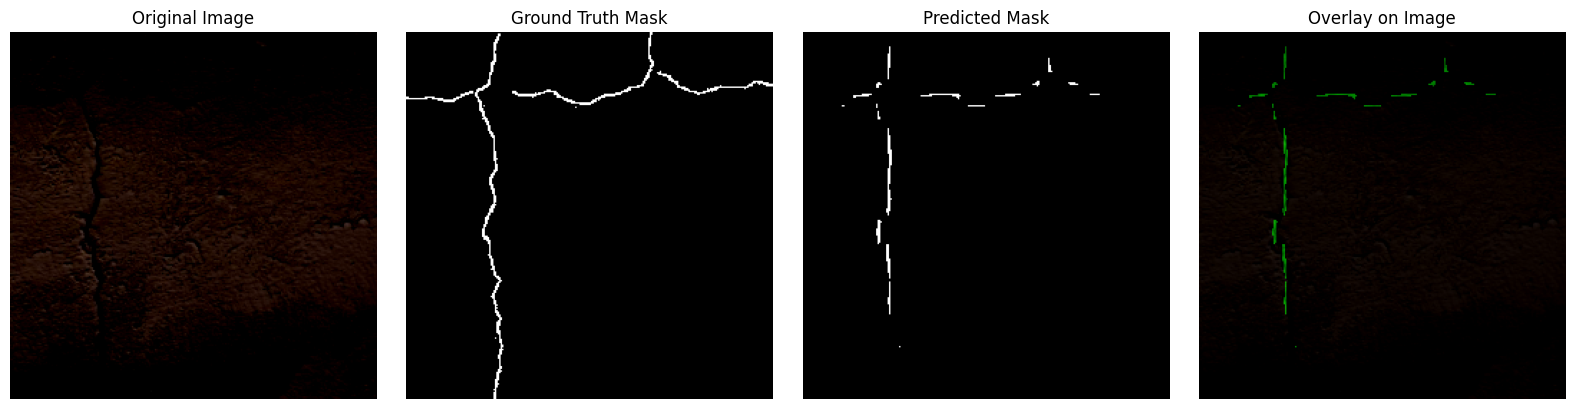

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


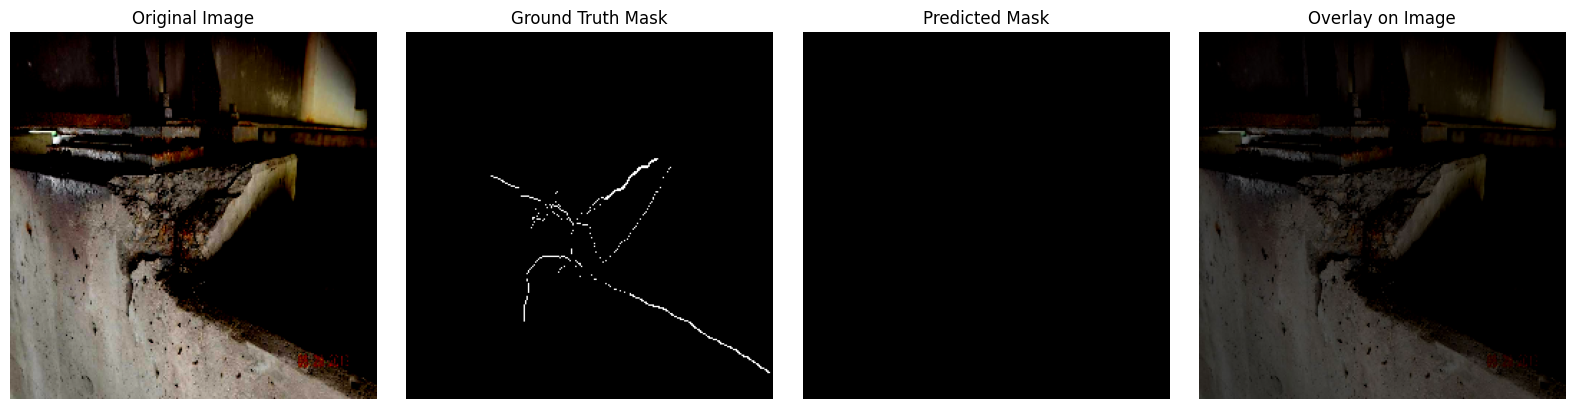

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3333333..1.0].


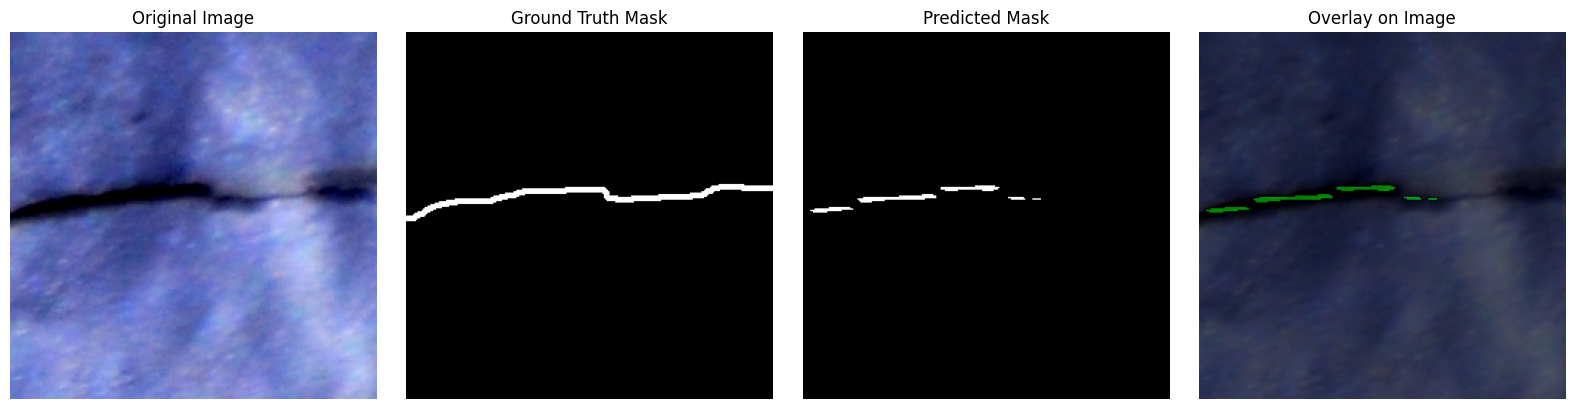

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


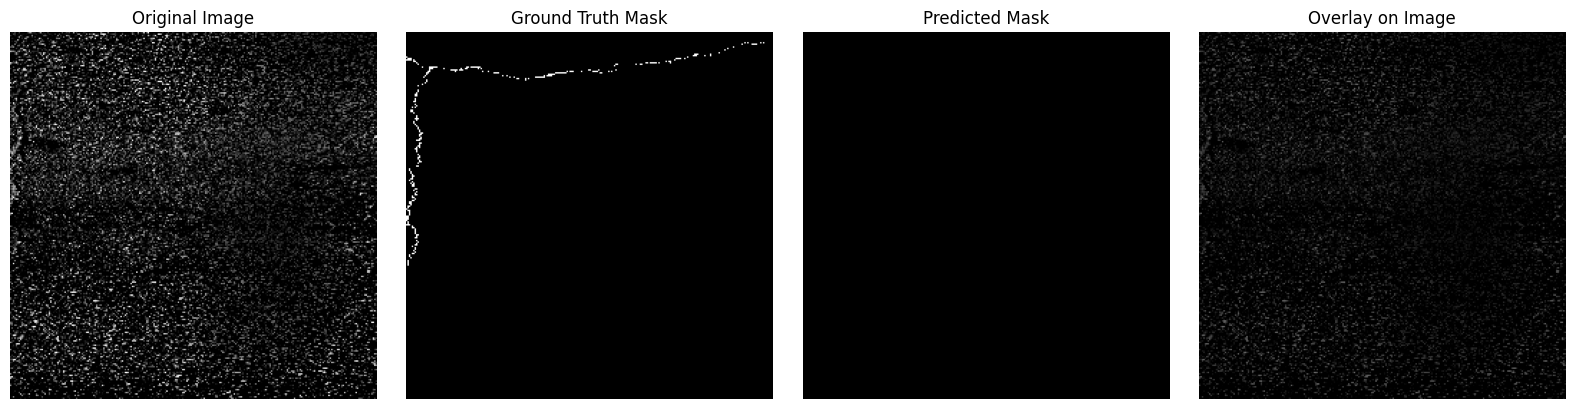


Average Dice Score on Test Set: 0.3925
Average IoU Score on Test Set: 0.3019


In [40]:
model = get_deeplabv3()
model.load_state_dict(torch.load('deepnetv3.pth', map_location=device))
model.to(device)

model.eval()
predict_and_evaluate(model, test_loader, save_dir="DeepLabv3_predicted_masks", threshold=0.5)

#### **Superpixel-Based Refinement via Majority Voting**

In [ ]:
from skimage.segmentation import slic
from skimage.color import label2rgb

def generate_superpixels(image, n_segments=300, compactness=10):
    if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

    superpixels = slic(image, n_segments=n_segments, compactness=compactness, start_label=0)
    return superpixels

In [44]:
from scipy import stats

def refine_with_superpixels(pred_mask, superpixels):
    refined_mask = np.zeros_like(pred_mask)

    for label in np.unique(superpixels):
        region_mask = (superpixels == label)
        majority_vote = stats.mode(pred_mask[region_mask].flatten(), keepdims=False).mode
        refined_mask[region_mask] = majority_vote

    return refined_mask

In [ ]:
def evaluation_with_superpixels_refinement(model, test_loader, save_dir, threshold=0.5, num_visualize=5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            preds = torch.sigmoid(outputs)
            preds_bin = (preds > threshold).float()

            for i in range(images.size(0)):
                image = images[i].cpu().permute(1, 2, 0).numpy()
                pred_mask = preds_bin[i].squeeze().cpu().numpy()

                superpixels = generate_superpixels(image, n_segments=300, compactness=10)

                refined_mask = refine_with_superpixels(pred_mask, superpixels)

                refined_img = Image.fromarray((refined_mask * 255).astype(np.uint8))
                refined_img.save(os.path.join(save_dir, f"refined_pred_{idx * test_loader.batch_size + i}.png"))

                if idx * test_loader.batch_size + i < num_visualize:
                    visualize_prediction(torch.tensor(image).permute(2, 0, 1), masks[i], torch.tensor(refined_mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.32549024].


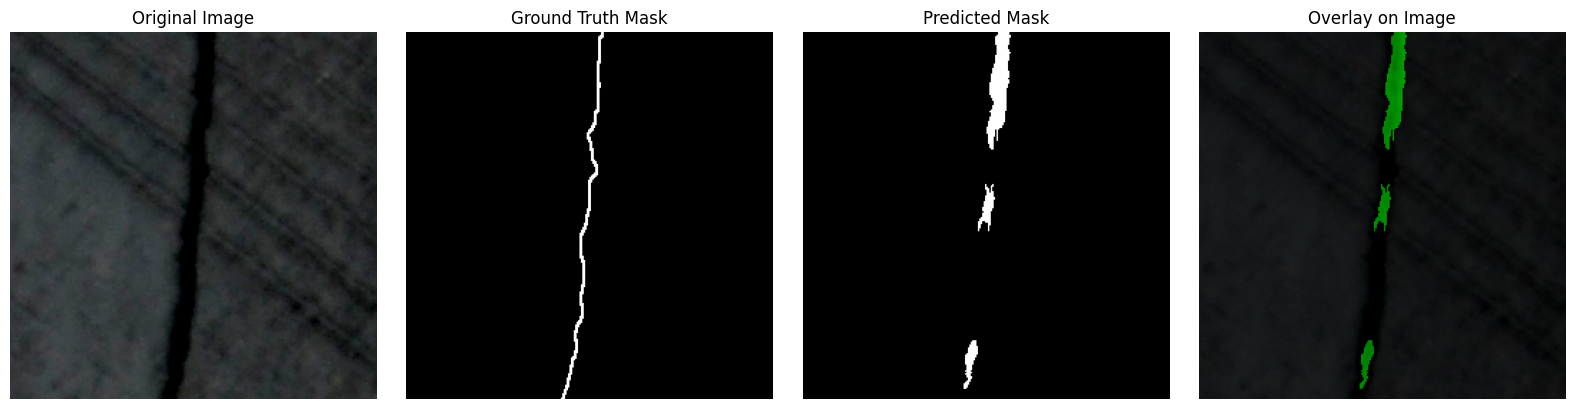

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.30980396].


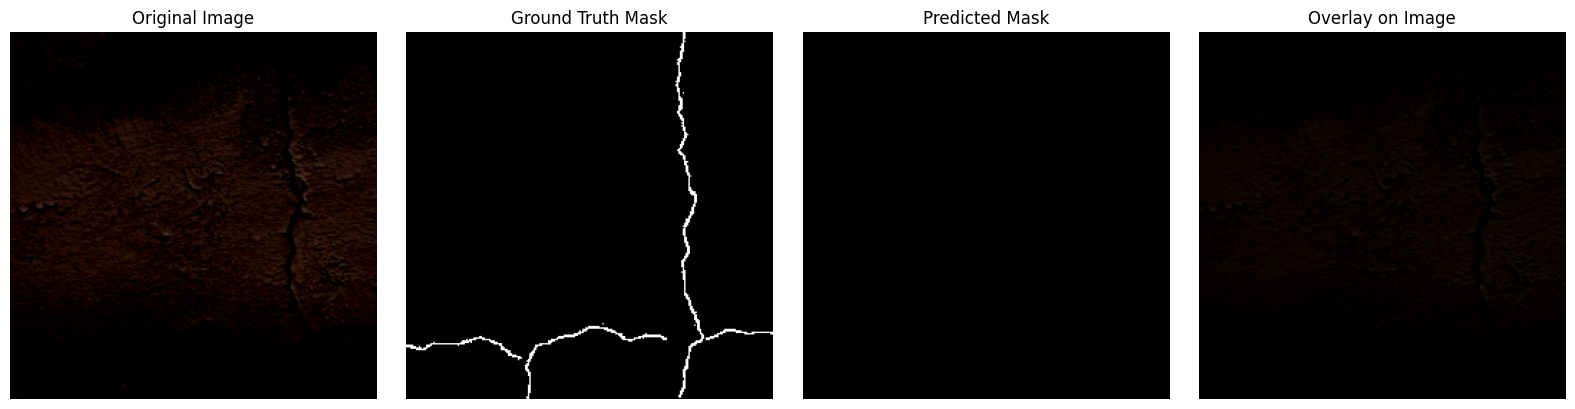

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


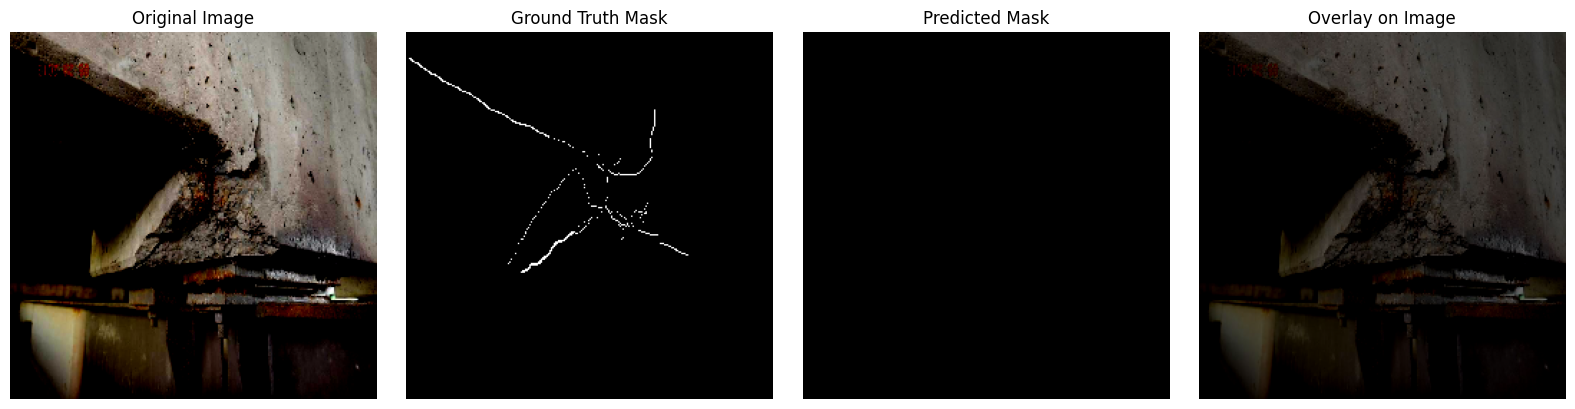

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3333333..1.0].


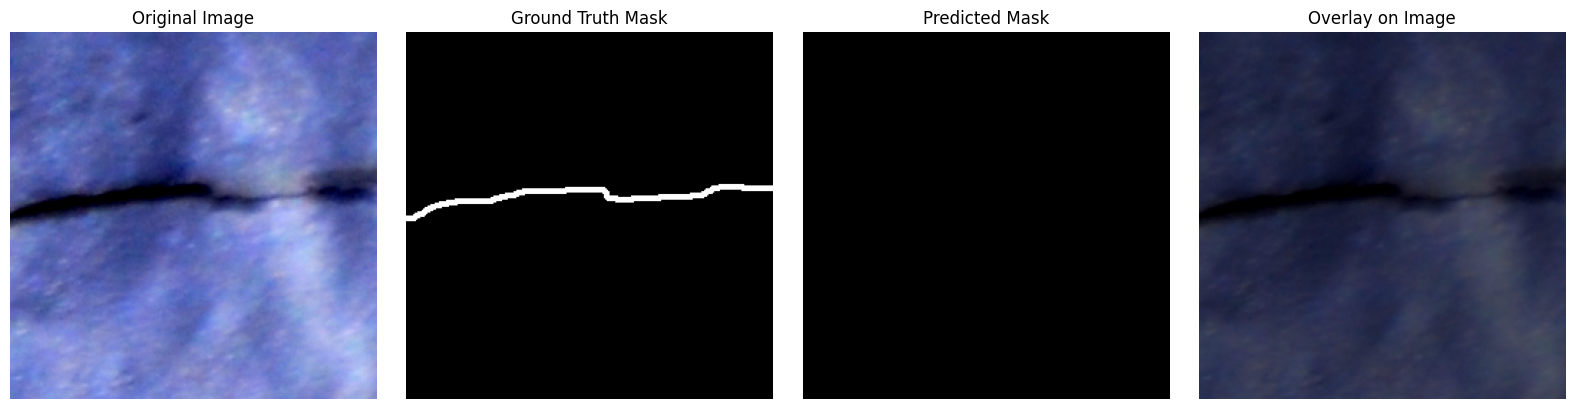

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


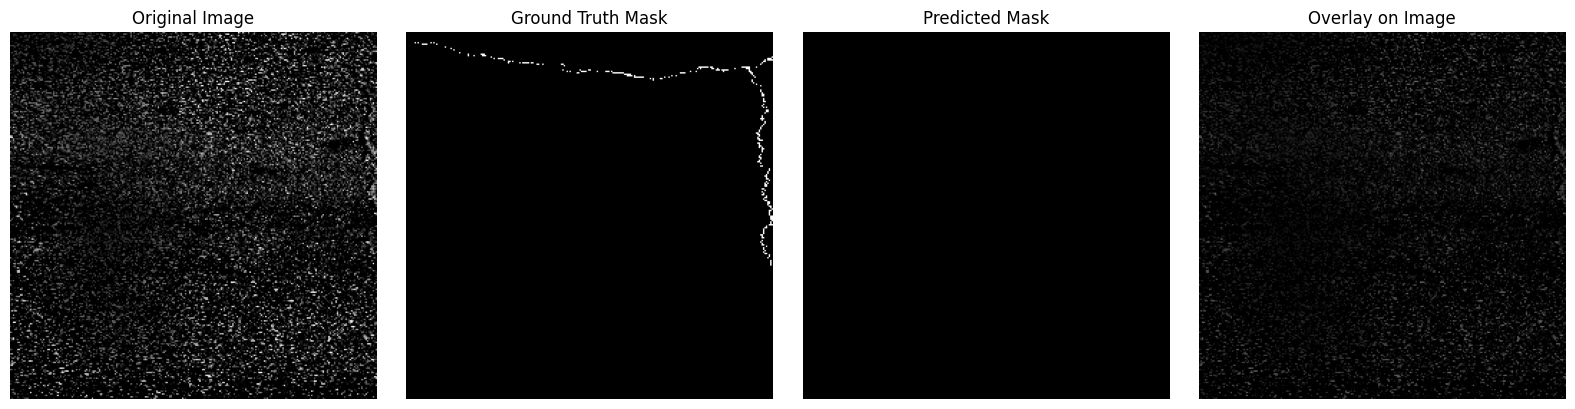

In [46]:
save_dir = "DeepLabv3_refined_predicted_masks"
evaluation_with_superpixels_refinement(model, test_loader, save_dir, threshold=0.5)

#### **Region Splitting and Merging-Based Refinement**

In [48]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects, remove_small_holes

In [ ]:
def region_based_split_and_merge(image, pred_mask, split_variance_thresh=0.01, merge_similarity_thresh=0.1, min_region_size=50):
    
    h, w = pred_mask.shape
    image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    labeled_mask = label(pred_mask)

    region_map = np.zeros_like(pred_mask)

    # Region Splitting
    label_counter = 1
    for region in regionprops(labeled_mask):
        coords = region.coords
        region_intensity = image_gray[tuple(zip(*coords))]
        region_variance = np.var(region_intensity)

        if region_variance > split_variance_thresh:
            # split into 2 by k-means clustering
            pixels = np.array([image[coord[0], coord[1]] for coord in coords])
            pixels = np.float32(pixels)
            _, labels, _ = cv2.kmeans(pixels, 2, None, 
                                      (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                                      3, cv2.KMEANS_RANDOM_CENTERS)
            labels = labels.flatten()
            for i, coord in enumerate(coords):
                region_map[coord[0], coord[1]] = label_counter + labels[i]
            label_counter += 2
        else:
            for coord in coords:
                region_map[coord[0], coord[1]] = label_counter
            label_counter += 1

    # Step 4.3: Region Merging
    final_map = region_map.copy()
    merged = set()
    for label1 in np.unique(region_map):
        if label1 == 0 or label1 in merged:
            continue

        mask1 = (region_map == label1)
        mean1 = np.mean(image[mask1], axis=0)

        for label2 in np.unique(region_map):
            if label2 == 0 or label2 == label1 or label2 in merged:
                continue

            mask2 = (region_map == label2)
            mean2 = np.mean(image[mask2], axis=0)

            # Merge if similar color mean
            if np.linalg.norm(mean1 - mean2) < merge_similarity_thresh:
                final_map[mask2] = label1
                merged.add(label2)

    # Step 4.4: Morphological Cleaning
    binary_mask = final_map > 0
    binary_mask = binary_fill_holes(binary_mask)
    binary_mask = remove_small_objects(binary_mask, min_size=min_region_size)
    binary_mask = remove_small_holes(binary_mask, area_threshold=min_region_size)

    # Step 4.5: Final Output
    return binary_mask.astype(np.uint8)

In [51]:
def apply_split_merge_refinement(model, test_loader, save_dir, threshold=0.5, num_visualize=5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)['out']
            preds = torch.sigmoid(outputs)
            preds_bin = (preds > threshold).float()

            for i in range(images.size(0)):
                image = images[i].cpu().permute(1, 2, 0).numpy()
                pred_mask = preds_bin[i].squeeze().cpu().numpy()

                # Apply Region Splitting and Merging Refinement
                refined_mask = region_based_split_and_merge(image, pred_mask)

                # Save
                refined_img = Image.fromarray((refined_mask * 255).astype(np.uint8))
                refined_img.save(os.path.join(save_dir, f"split_merge_refined_{idx * test_loader.batch_size + i}.png"))

                if idx * test_loader.batch_size + i < num_visualize:
                    visualize_prediction(torch.tensor(image).permute(2, 0, 1), masks[i], torch.tensor(refined_mask))

    print("Region splitting & merging-based refinement complete.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.32549024].


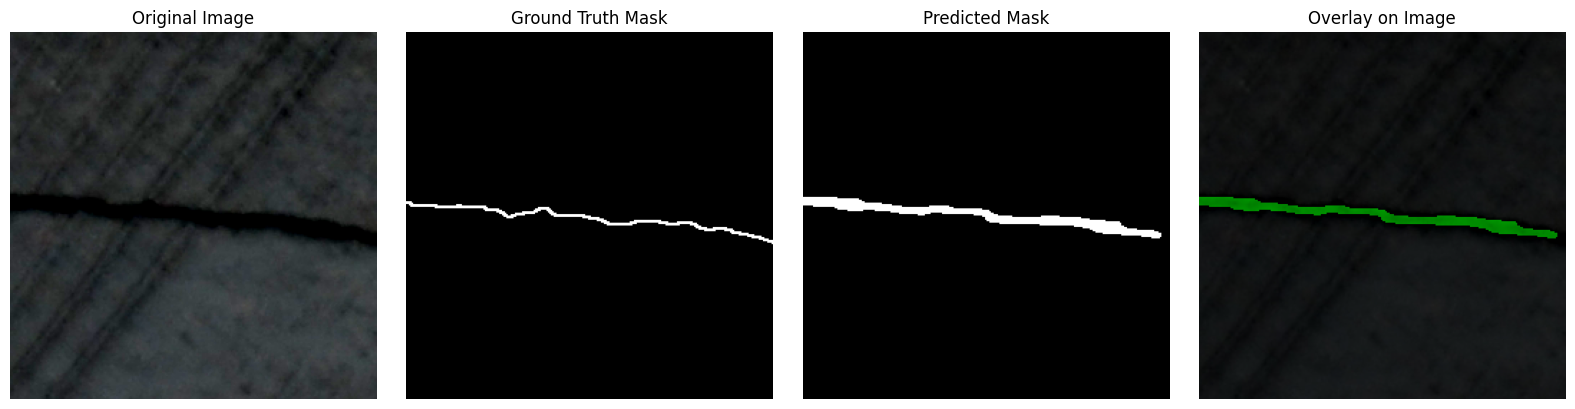

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.30980396].


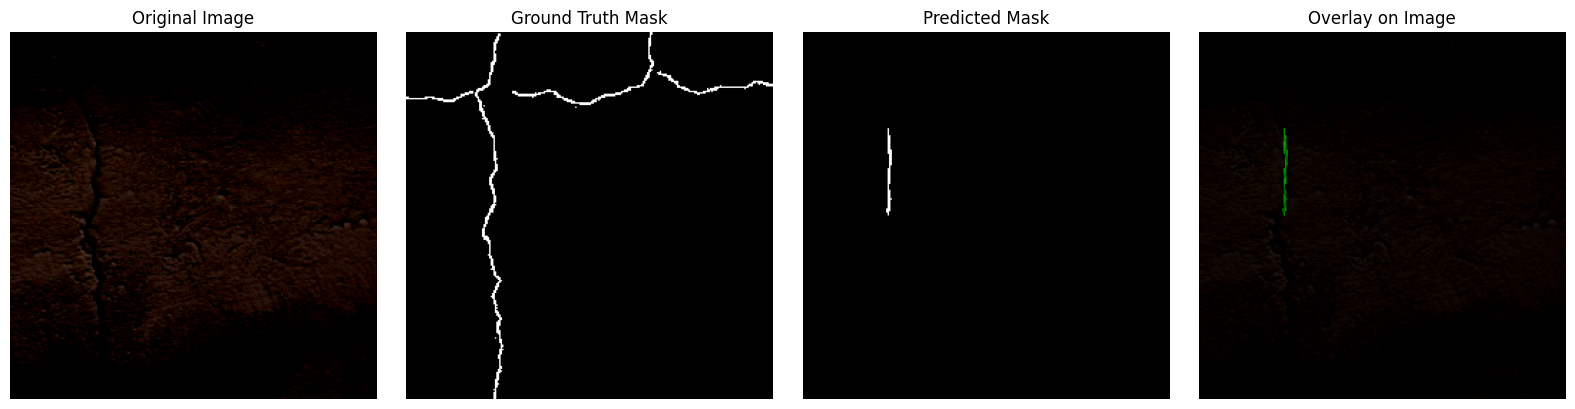

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


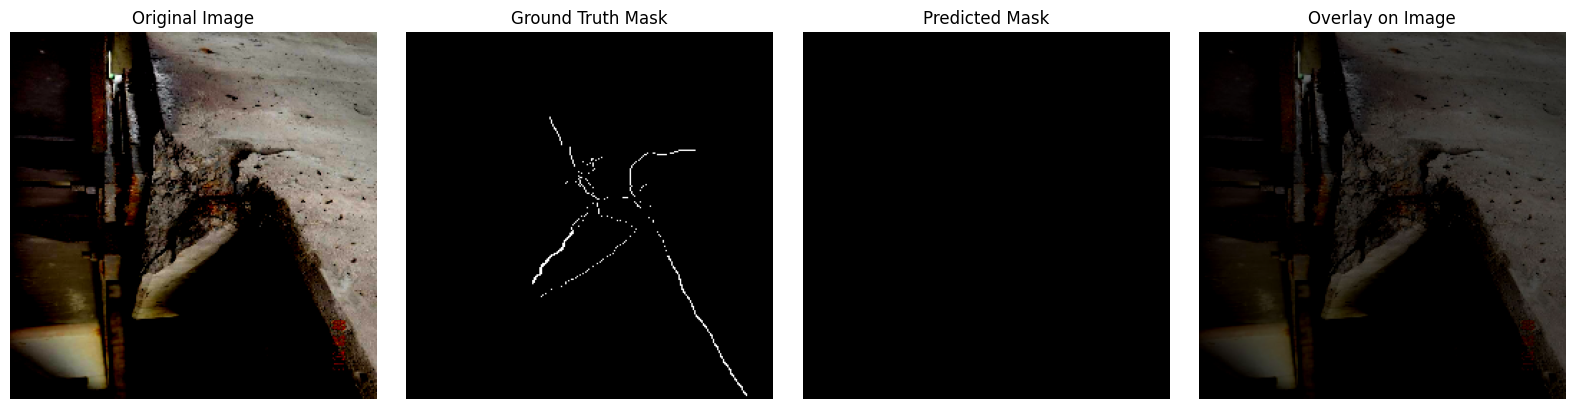

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3333333..1.0].


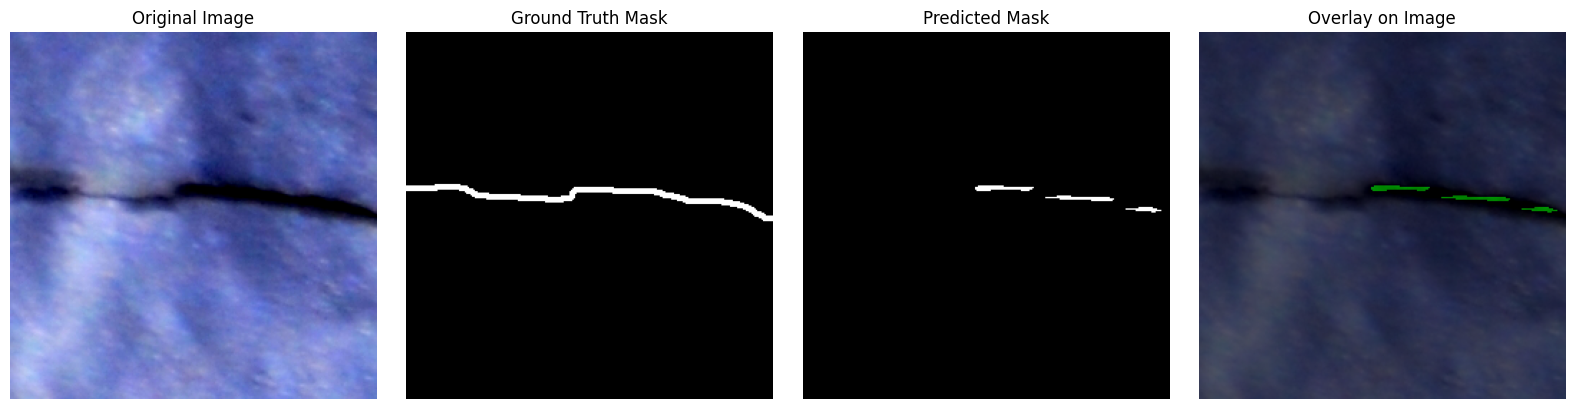

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


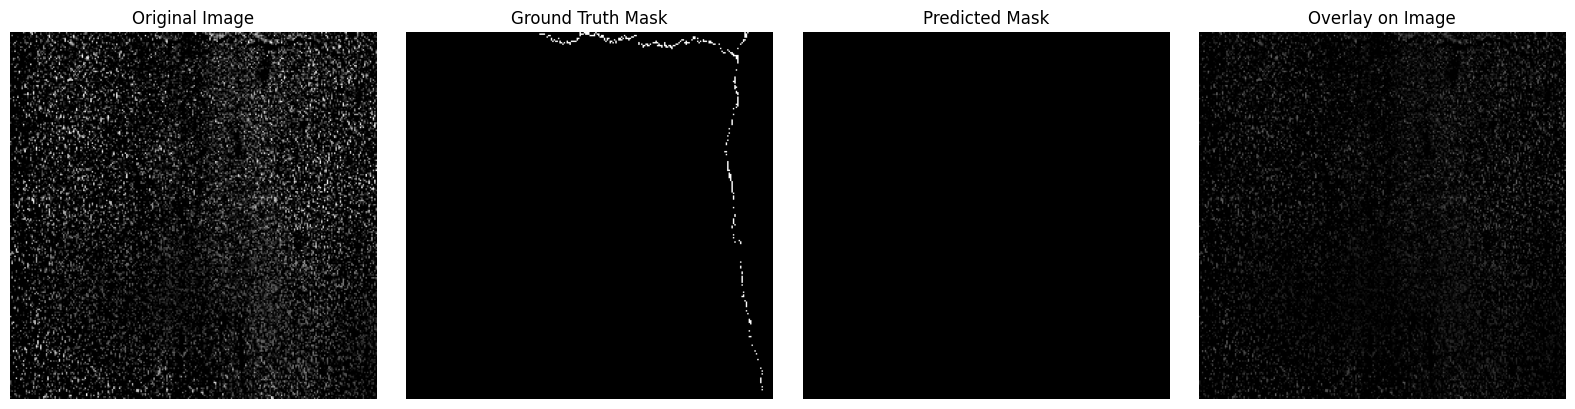

Region splitting & merging-based refinement complete.


In [53]:
save_dir = "Region_Based"
apply_split_merge_refinement(model, test_loader, save_dir, threshold=0.5)

In [54]:
def visualize_full_pipeline(image, mask, pred_mask, slic_refined, region_refined):
    """
    Display the original image, ground truth, predicted mask, 
    slic-refined mask, and region-based refined mask side by side.
    """
    image = image.cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    mask = mask.cpu().squeeze().numpy()
    pred_mask = pred_mask.squeeze()
    slic_refined = slic_refined.squeeze()
    region_refined = region_refined.squeeze()

    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")

    axs[3].imshow(slic_refined, cmap='gray')
    axs[3].set_title("SLIC Refined")

    axs[4].imshow(region_refined, cmap='gray')
    axs[4].set_title("Region-Based Refined")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.32549024].


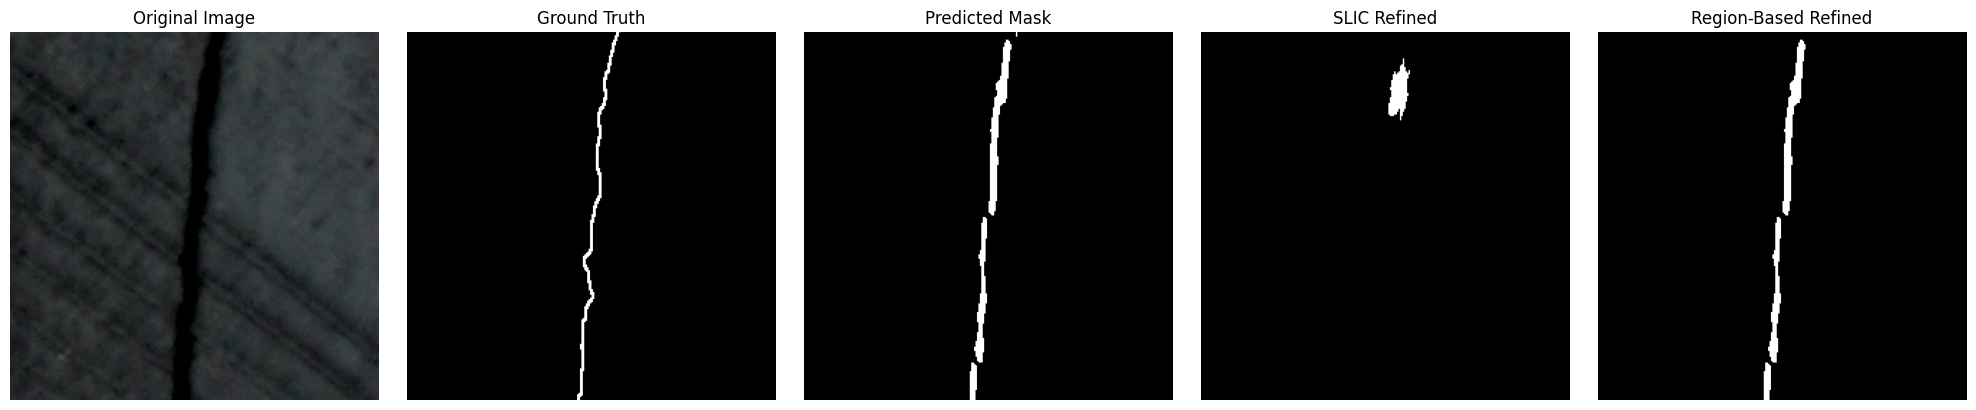

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.30980396].


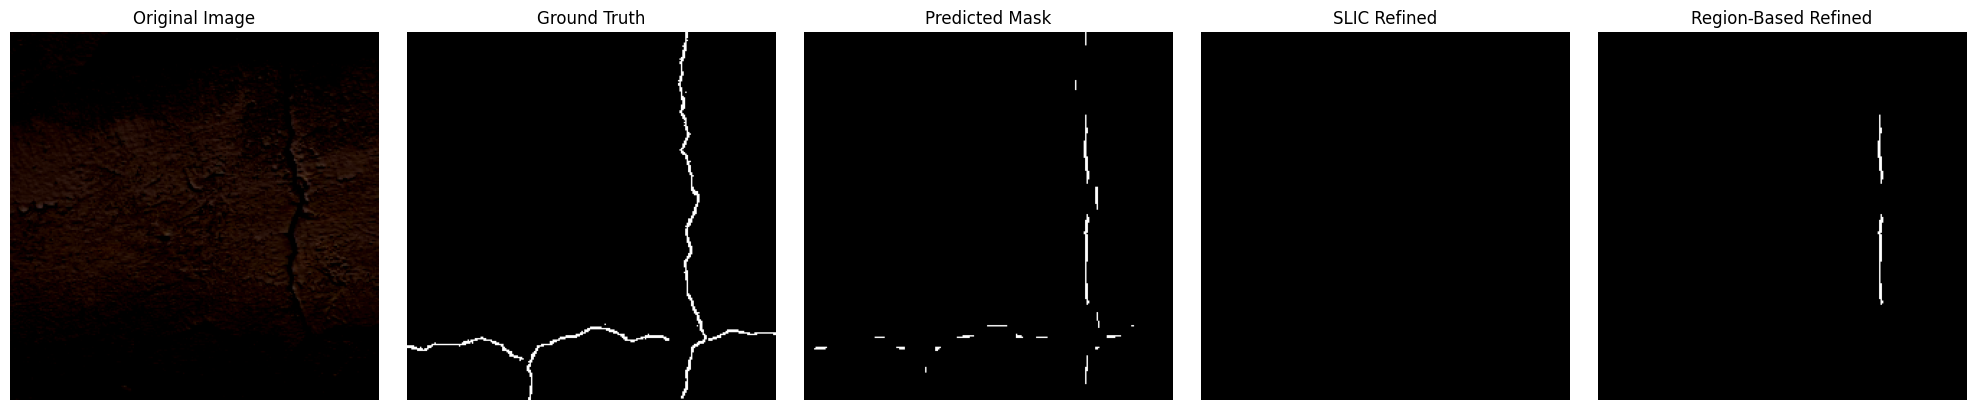

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


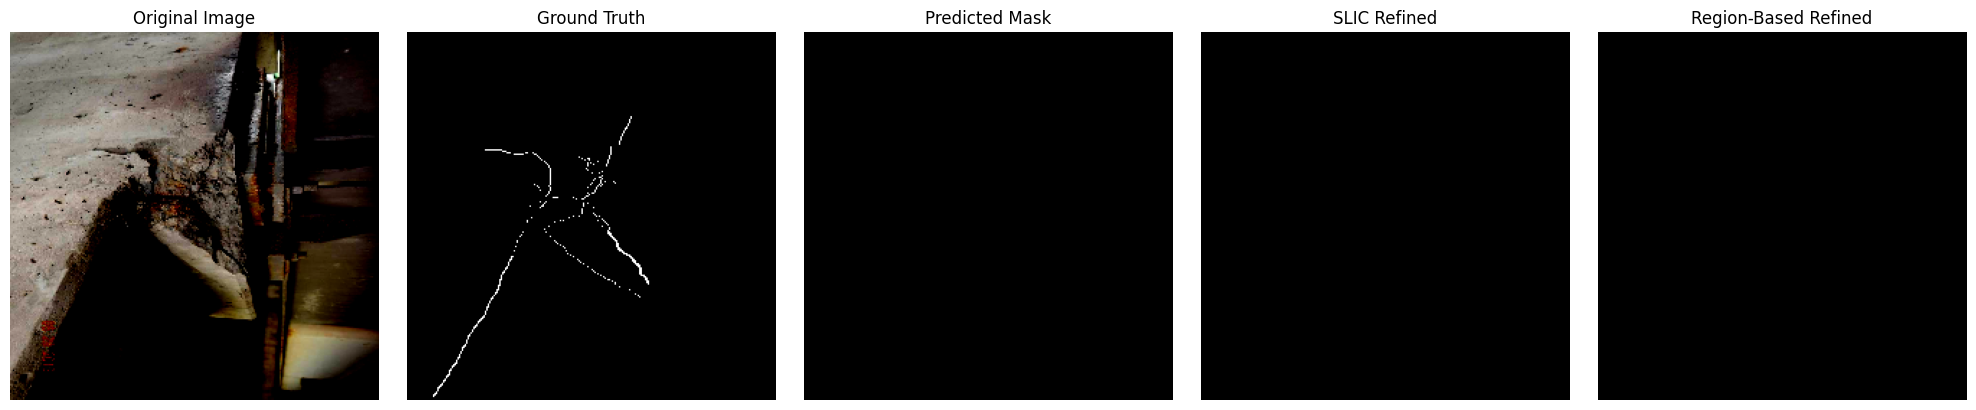

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3333333..1.0].


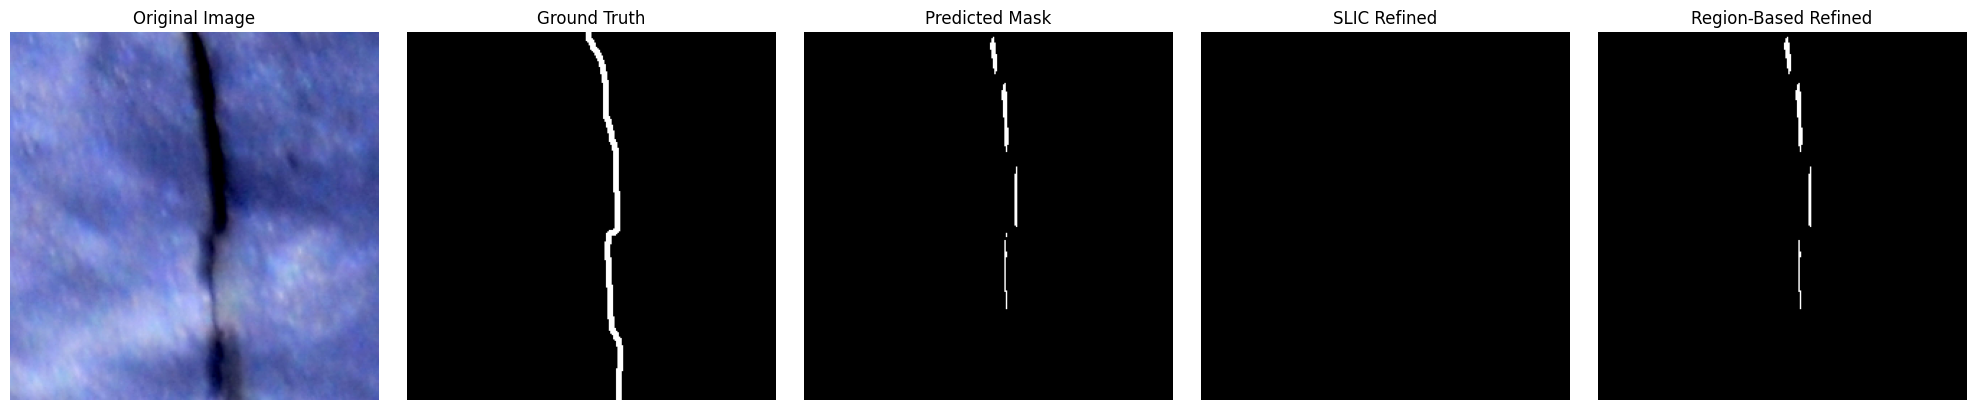

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


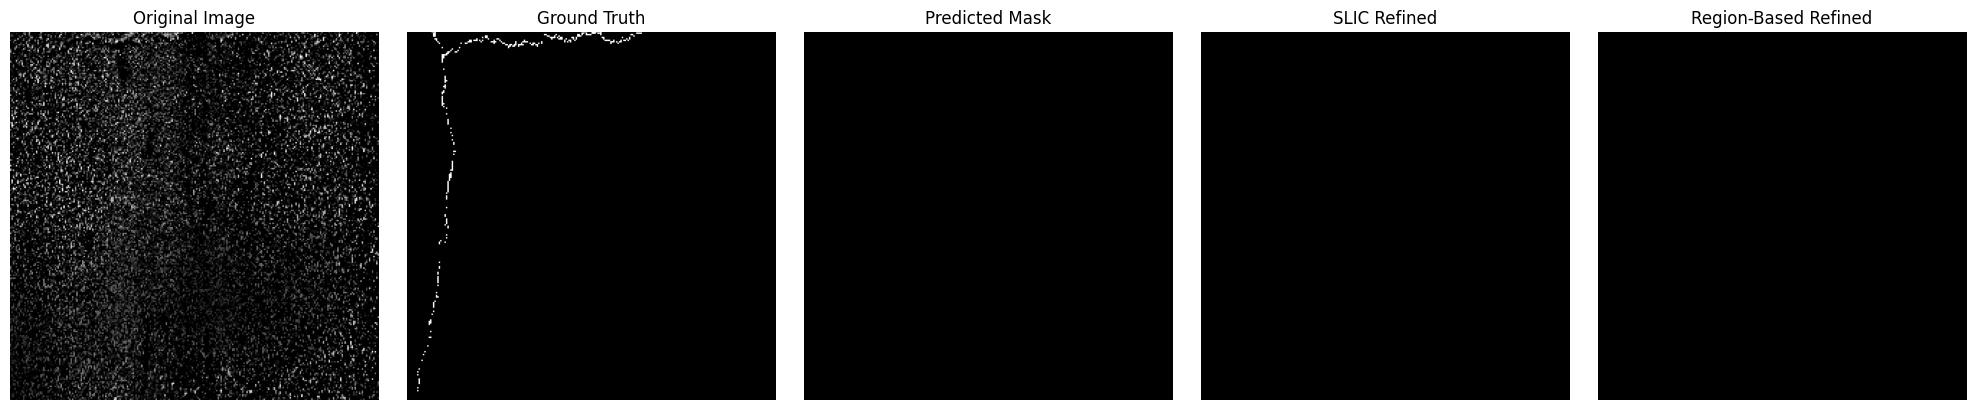

In [55]:
# Visualization for a few test images
num_visualize = 5
model.eval()

with torch.no_grad():
    for idx in range(num_visualize):
        image, mask = test_dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        output = model(image_input)['out']
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_bin = (pred > 0.5).astype(np.uint8)

        image_np = image.permute(1, 2, 0).numpy()

        # Apply Superpixel refinement
        superpixels = generate_superpixels(image_np)
        slic_refined = refine_with_superpixels(pred_bin, superpixels)

        # Apply Region Splitting & Merging refinement
        region_refined = region_based_split_and_merge(image_np, pred_bin)

        # Show all in one plot
        visualize_full_pipeline(image, mask, pred_bin, slic_refined, region_refined)